# Preprocessing Steam Games

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import os
from enum import Enum, auto

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings('ignore')

import ast
from collections import Counter
from wordcloud import WordCloud
# from sentence_transformers import SentenceTransformer

from numpy import unique
from scipy.stats import skew

## Define Target/Label Type

We have 2 datasets, one in which the target is regression and another in which the target is classification, the below `TARGET_TYPE` decides if we are working on the regression or classification target.

In [2]:
class TargetType(Enum):
    REGRESSION = auto()
    CLASSIFICATION = auto()

TARGET_TYPE = TargetType.CLASSIFICATION

## Load Data

In [3]:
# Define file paths
DEMOS_PATH = '../../data/raw/demos.csv'
DLCS_PATH = '../../data/raw/dlcs.csv'
BASE_GAMES_PATH = '../../data/raw/info_base_games.csv'
OUTPUT_PATH = '../../data/preprocessed/'

if TARGET_TYPE == TargetType.REGRESSION:
    GAMALYTIC_PATH = '../../data/raw/gamalytic_steam_games.csv'
elif TARGET_TYPE == TargetType.CLASSIFICATION:
    GAMALYTIC_PATH = '../../data/raw/ms2_gamalytic_steam_games.csv'

# Read CSV files
demo_df = pd.read_csv(DEMOS_PATH)
dlc_df = pd.read_csv(DLCS_PATH)
info_base_games_df = pd.read_csv(BASE_GAMES_PATH, low_memory=False)
gamalytic_steam_games_df = pd.read_csv(GAMALYTIC_PATH)

## Explore Data

In [4]:
print(info_base_games_df.shape)
print(gamalytic_steam_games_df.shape)
print(demo_df.shape)
print(dlc_df.shape)

print("Info Base Games File Columns:", info_base_games_df.columns.tolist())
print("Gamalytic Steam Games File Columns:", gamalytic_steam_games_df.columns.tolist())
print("Demo File Columns:", demo_df.columns.tolist())
print("DLC File Columns:", dlc_df.columns.tolist())

(99167, 10)
(93338, 6)
(15449, 4)
(5445, 3)
Info Base Games File Columns: ['appid', 'name', 'metacritic', 'steam_achievements', 'steam_trading_cards', 'workshop_support', 'genres', 'achievements_total', 'release_date', 'supported_platforms']
Gamalytic Steam Games File Columns: ['steamId', 'price', 'copiesSold', 'publisherClass', 'reviewScore', 'aiContent']
Demo File Columns: ['Unnamed: 0', 'full_game_appid', 'demo_appid', 'name']
DLC File Columns: ['base_appid', 'dlc_appid', 'name']


## Preprocessing DLCs and Demos CSVs

### Statistics Before Preprocessing

In [5]:
demo_df.info()
dlc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15449 entries, 0 to 15448
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       15449 non-null  int64 
 1   full_game_appid  15449 non-null  object
 2   demo_appid       15449 non-null  object
 3   name             15448 non-null  object
dtypes: int64(1), object(3)
memory usage: 482.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5445 entries, 0 to 5444
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   base_appid  5445 non-null   object
 1   dlc_appid   5445 non-null   object
 2   name        5445 non-null   object
dtypes: object(3)
memory usage: 127.7+ KB


### Preprocessing

#### Drop auto_incremented columns

In [6]:
demo_df.drop("Unnamed: 0", axis=1, inplace=True)

print("Demo File Columns:", demo_df.columns.tolist())
print("DLC File Columns:", dlc_df.columns.tolist())

Demo File Columns: ['full_game_appid', 'demo_appid', 'name']
DLC File Columns: ['base_appid', 'dlc_appid', 'name']


#### Standardize column names

In [7]:
demo_df.rename(columns={"full_game_appid": "appid"}, inplace=True)
dlc_df.rename(columns={"base_appid": "appid"}, inplace=True)

print("\nAfter Standardizing Column Names:\n")
print("Demo File Columns:", demo_df.columns.tolist())
print("DLC File Columns:", dlc_df.columns.tolist())


After Standardizing Column Names:

Demo File Columns: ['appid', 'demo_appid', 'name']
DLC File Columns: ['appid', 'dlc_appid', 'name']


#### Handle missing values

In [8]:
original_len_demo = len(demo_df)
original_len_dlc = len(dlc_df)
demo_df.dropna(inplace=True)
dlc_df.dropna(inplace=True)

print(f"Dropped {original_len_demo - len(demo_df)} rows in Demo DataFrame due to missing values.")
print(f"Remaining rows in Demo DataFrame: {len(demo_df)}\n")
print(f"Dropped {original_len_dlc - len(dlc_df)} rows in DLC DataFrame due to missing values.")
print(f"Remaining rows in DLC DataFrame: {len(dlc_df)}")

Dropped 1 rows in Demo DataFrame due to missing values.
Remaining rows in Demo DataFrame: 15448

Dropped 0 rows in DLC DataFrame due to missing values.
Remaining rows in DLC DataFrame: 5445


#### Convert data types

- errors="coerce" means that if a value cannot be converted to a number **"id is not a number"** it's replaced by NaN
- It then gets removed by dropna() function

In [9]:
original_len_demo = len(demo_df)
original_len_dlc = len(dlc_df)

for df, appid_col in [(demo_df, "demo_appid"), (dlc_df, "dlc_appid")]:
    df[appid_col] = pd.to_numeric(df[appid_col], errors="coerce") 
    df["appid"] = pd.to_numeric(df["appid"], errors="coerce")

    # Drop rows where appid or demo/dlc_appid is missing/NaN
    df.dropna(subset=[appid_col, "appid"], inplace=True)

    df[appid_col] = df[appid_col].astype(int)
    df["appid"] = df["appid"].astype(int)
    df["name"] = df["name"].astype(str)

print(f"Dropped {original_len_demo - len(demo_df)} rows in Demo DataFrame due to missing values.")
print(f"Remaining rows in Demo DataFrame: {len(demo_df)}\n")
print(f"Dropped {original_len_dlc - len(dlc_df)} rows in DLC DataFrame due to missing values.")
print(f"Remaining rows in DLC DataFrame: {len(dlc_df)}")


Dropped 1 rows in Demo DataFrame due to missing values.
Remaining rows in Demo DataFrame: 15447

Dropped 1 rows in DLC DataFrame due to missing values.
Remaining rows in DLC DataFrame: 5444


#### Remove duplicates by unique identifier

- **demo_appid**: In the DEMOs file
- **dlc_appid**: In the DLCs file

In [10]:
demo_duplicates = demo_df.duplicated(subset=["demo_appid"]).sum()
dlc_duplicates = dlc_df.duplicated(subset=["dlc_appid"]).sum()
demo_df.drop_duplicates(subset=["demo_appid"], inplace=True)
dlc_df.drop_duplicates(subset=["dlc_appid"], inplace=True)
print(f"Dropped {demo_duplicates} duplicate rows in Demo DataFrame based on demo_appid.")
print(f"Dropped {dlc_duplicates} duplicate rows in DLC DataFrame based on dlc_appid.")

Dropped 0 duplicate rows in Demo DataFrame based on demo_appid.
Dropped 0 duplicate rows in DLC DataFrame based on dlc_appid.


#### Clean the 'name' column

- By removing any leading or trailing whitespace from the 'name' column.
- By removing any non-alphanumeric characters from the 'name' column.
- By removing 'Demo' and 'DLC' from the 'name' column.

In [11]:
def clean_name_column(df, column_name):
    df[column_name] = (df[column_name]
                      .str.replace(r"(?i)\bdemo\b", "", regex=True)
                      .str.replace(r"(?i)\bdlc\b", "", regex=True)
                      .str.replace(r"\s+", " ", regex=True)
                      .str.strip()
                      .str.title())
    return df

demo_df = clean_name_column(demo_df, "name")
dlc_df = clean_name_column(dlc_df, "name")

#### Reset Indicies

- Reset the indices of the dataframe to the original order.

In [12]:
demo_df.reset_index(drop=True, inplace=True)
dlc_df.reset_index(drop=True, inplace=True)

### Extracting new features

#### Create indicator and count features

In [13]:
def create_indicator_features(df, group_by_col, count_col, feature_prefix):

    # group by appid to count the demo/dlc count for each game 
    indicators = df.groupby(group_by_col)[count_col].count().reset_index()
    
    # create has_feature column
    indicators[f'has_{feature_prefix}'] = 1

    # create count column
    indicators[f'{feature_prefix}_count'] = indicators[count_col]
    
    # e.g.: return demo_df[['appid', 'has_demo', 'demo_count']]  
    return indicators[[group_by_col, f'has_{feature_prefix}', f'{feature_prefix}_count']]

demo_indicators = create_indicator_features(demo_df, 'appid', 'demo_appid', 'demo')
dlc_indicators = create_indicator_features(dlc_df, 'appid', 'dlc_appid', 'dlc')

### Statistics After Preprocessing

In [14]:
demo_df.info()
dlc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15447 entries, 0 to 15446
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   appid       15447 non-null  int64 
 1   demo_appid  15447 non-null  int64 
 2   name        15447 non-null  object
dtypes: int64(2), object(1)
memory usage: 362.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5444 entries, 0 to 5443
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   appid      5444 non-null   int64 
 1   dlc_appid  5444 non-null   int64 
 2   name       5444 non-null   object
dtypes: int64(2), object(1)
memory usage: 127.7+ KB


### Summary

In [15]:
print("\nPreprocessing Summary:\n")
print(f"Demo DataFrame: {len(demo_df)} rows, {len(demo_df.columns)} columns")
print(f"DLC DataFrame: {len(dlc_df)} rows, {len(dlc_df.columns)} columns\n")

print(dlc_df.head())
print("\n")
print(demo_df.head())


Preprocessing Summary:

Demo DataFrame: 15447 rows, 3 columns
DLC DataFrame: 5444 rows, 3 columns

     appid  dlc_appid                                             name
0  1786750    2568660                        家出王女 - 全年齢版ストーリー&グラフィック追加
1  1981700    2563730                           Jacob'S Quest - Voyage
2  2009450    2552980  Invector: Rhythm Galaxy - Latin Power Song Pack
3  1133420    2550750         Hero Or Villain: Genesis — Supercharged!
4  2533950    2551000            Hot And Lovely ：Uniform - Adult Patch


     appid  demo_appid                    name
0  2214650     2573370          Rolando Deluxe
1  1439980     2573460  Outrunner: Neon Nights
2  2412240     2572840     Bubble Ghost Remake
3  2448830     2572240           Time Handlers
4  2379590     2570800    Hope'S Final Defense


## Preprocessing Game Base Info CSV

### Preprocess Release Date Column

In [16]:
#info_base_games_df
#print(info_base_games_df.shape)
#info_base_games_df.describe()

info_base_games_df['release_date'].isnull().sum()
#pd.set_option('display.max_rows', None)
#info_base_games_df['release_date'].value_counts()

#(info_base_games_df['release_date'] == "Coming soon").sum()  
#(info_base_games_df['release_date'] == "to be announced").sum() 
#keywords = ['vr', 'remaster', 'collector', 'collection', 'edition', 'bundle', 'playtest']
#pattern = r'\b(' + '|'.join(re.escape(k) for k in keywords) + r')\b'  # Escaping protects against regex special chars
#info_base_games_df[info_base_games_df['name'].str.contains(pattern, regex=True, flags=re.IGNORECASE)]

np.int64(306)

In [17]:
#If there are no parentheses in pattern, .groups() returns an empty tuple.
info_base_games_df.dropna(subset=['release_date'],inplace=True)
info_base_games_df['release_date'] = info_base_games_df['release_date'].astype(str).str.strip().str.lower() # to remove any leading or trailing spaces if exist

YEAR_DATA_COLLECTED = 2024
# ^: start of string , $: end of string
unknown_release_dates = [
    r'^coming soon$',
    r'^to be announced$',
    r'^\s*$',  # empty string
    r'^q[1-4][^a-zA-Z0-9]+\d{4}$', #q2 2025
    r'\d{4}$',  # year only
    r'^\d{1,2}[^a-zA-Z0-9]+[A-Za-z]{3}$' # DAY MONTH
]
def has_known_release(x):
    x = str(x).strip().lower()
    for pattern in unknown_release_dates:
        if re.match(pattern, x):
            return 0
    return 1
info_base_games_df['is_release_date_known'] = info_base_games_df['release_date'].apply(has_known_release)

# I don't we should add "Coming soon" as it is upcoming game or not
# [^a-zA-Z0-9]+ : continue taking if not alphanumeric , [^0-9]+ : continue taking if not number
def preprocess_release_date(x):
    x = str(x).strip()

    # 8-Dec-2022 or 8 Dec 2022
    match = re.search(r'(\d{1,2})[^a-zA-Z0-9]+([A-Za-z]{3})[^a-zA-Z0-9]+(\d{2,4})', x)
    if match:
        day, month, year = match.groups()
        if(int(year) > YEAR_DATA_COLLECTED):
            return f"{day} {month} {year}" , 1
        return f"{day} {month} {year}" , 0

    # Dec-8-2022 or Dec 8, 2022
    match = re.search(r'([A-Za-z]{3})[^a-zA-Z0-9]+(\d{1,2})[^a-zA-Z0-9]+(\d{4})', x)
    if match:
        month, day, year = match.groups()
        if(int(year) > YEAR_DATA_COLLECTED):
            return f"{day} {month} {year}" , 1
        return f"{day} {month} {year}" , 0

    # Dec-2022 or Dec 2022
    match = re.search(r'([A-Za-z]{3})[^a-zA-Z0-9]+(\d{2,4})', x)
    if match:
        month, year = match.groups()
        if(int(year) > YEAR_DATA_COLLECTED):
            return f"15 {month} {year}" , 1
        return f"15 {month} {year}" , 0
        

    # 8-Dec (no year)
    match = re.search(r'(\d{1,2})[^a-zA-Z0-9]+([A-Za-z]{3})', x)
    if match:
        return np.nan,0

    # q1 2023, q2-2024
    match = re.search(r'(q[1-4])[^a-zA-Z0-9]+(\d{4})', x, re.IGNORECASE)
    if match:
        q, y = match.groups()
        q = q.lower()
        quarter_map = {
            'q1': '15 Feb',
            'q2': '15 May',
            'q3': '15 Aug',
            'q4': '15 Nov',
        }
        if(int(y) > YEAR_DATA_COLLECTED):
            return f"{quarter_map[q]} {y}" , 1
        return f"{quarter_map[q]} {y}" , 0

    # 2023 (year only)
    if re.fullmatch(r'\d{4}', x):
        year = int(x)
        if YEAR_DATA_COLLECTED < year:
            return f"1 Jun {x}" , 1
        else:
            return f"1 JAN {x}" , 0


    # "Coming soon", "To be announced", ... etc.
    return np.nan,0

# for each value in column release date we will apply this function to it 
#info_base_games_df['release_date'] , info_base_games_df['is_upcoming']  = info_base_games_df['release_date'].apply(preprocess_release_date)
info_base_games_df[['release_date', 'is_upcoming']] = info_base_games_df['release_date'].apply(preprocess_release_date).apply(pd.Series) # for unpacking the series tuple into 2 columns

In [18]:
info_base_games_df['release_date'] = pd.to_datetime(info_base_games_df['release_date'], errors='coerce') 

info_base_games_df['year'] = info_base_games_df['release_date'].dt.year.fillna(0).astype(int)
#fraction_of_year = np.where(info_base_games_df['is_release_date_known'], (info_base_games_df['release_date'].dt.dayofyear - 1) / 365, 0)
# np.where(condition,iftrue,iffalse)
fraction_of_year = np.where(~info_base_games_df['release_date'].isna(), (info_base_games_df['release_date'].dt.dayofyear - 1) / 365, -1)
info_base_games_df['sin_day'] = np.where(fraction_of_year == -1, 0, np.sin(2 * np.pi * fraction_of_year))
info_base_games_df['cos_day'] = np.where(fraction_of_year == -1, 0, np.cos(2 * np.pi * fraction_of_year))
#info_base_games_df['sin_day'].fillna(0, inplace=True)
#info_base_games_df['cos_day'].fillna(0, inplace=True)
info_base_games_df.drop('release_date',axis=1,inplace=True)


#### Checking missing data

In [19]:
#print(info_base_games_df['is_release_date_known'].shape)
#print(info_base_games_df['year'].shape)
#print(info_base_games_df['sin_day'].shape)
#print(info_base_games_df['cos_day'].shape)
print(info_base_games_df['is_release_date_known'].isnull().sum())
print(info_base_games_df['year'].isnull().sum())
print(info_base_games_df['sin_day'].isnull().sum())
print(info_base_games_df['cos_day'].isnull().sum())
print(info_base_games_df['is_upcoming'].isnull().sum())

0
0
0
0
0


#### Final Thoughts

- First approach

    - just consider only "year" column and ignore day and month 

- Second approach

    - Create new column for binary feature is_release_date_known
    1 indicates a specific date or quarter is known.
    0 indicates the entry is "to be announced" or "coming soon".
    For the main release date feature (fractional_year) = year + (day of year - 1)/days in year

- Third approach

    - guide : https://medium.com/%40paghadalsneh/handling-date-and-time-data-in-machine-learning-a-comprehensive-guide-5d30141cbfec 

    - splitting date into 3 features (day,month,year)

- Fourth approach

    - using Cyclical encoding 

- Fifth Approach 

    - Creating two boolean features (I think the two together may be good combination )

        - *is_release_date_known* : A missingness indicator set to 1 if game has a specific past or present date (e.g. “15 Apr 2024” or “2023-08-05”), and 0 if (“coming soon”, “to be announced”, “Q[1–4] YYYY”, or “YYYY” only)

        - *is_upcoming* : A flag set to 1 if a game release date is strictly after the date when data collected, and 0 otherwise.

    - Creating "year" , "fraction_of_year_sin" , "fraction_of_year_cos" features 
    so Here we applied Cyclical encoding for not missing seasonal patterns 

    - There are many updates we can do but I don't know it will help or not, We need to select features first to be able to test
    like in Q[1-4] yyyy or yyyy only 
    we can fill it by mode of month and median of days, and maybe in each quarter calculate mean or use imputers

### Preprocess Metacritic Column

#### Checking null values

In [20]:
info_base_games_df.isna().sum().sort_values(ascending = False)

metacritic               95856
achievements_total       60774
genres                    4752
name                        14
appid                        0
steam_achievements           0
steam_trading_cards          0
workshop_support             0
supported_platforms          0
is_release_date_known        0
is_upcoming                  0
year                         0
sin_day                      0
cos_day                      0
dtype: int64

#### Drop Corrupted Sample That Contains The Column Names

In [21]:
info_base_games_df.loc[[9929]]

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,supported_platforms,is_release_date_known,is_upcoming,year,sin_day,cos_day
9929,steam_appid,name,metacritic,True,True,True,genres,achievements_total,"['windows', 'mac', 'linux']",1,0.0,0,0.0,0.0


In [22]:
info_base_games_df = info_base_games_df.drop(index=9929)

#### Preprocessing The Metacritic Score Column

[Metacritic](https://www.metacritic.com/) is a website for critics and users to review digital content (movies, music, **games**, etc.), the metacritic score that is included on Steam is the **critics** (professional game reviewers) metacritic score, not the users.

In [23]:
# Converting the metacritic column to numeric since it contains NaNs
info_base_games_df['metacritic'] = pd.to_numeric(info_base_games_df['metacritic'], errors='coerce')

#### Checking Percentage of Missing Values

In [24]:
total = len(info_base_games_df)
non_null = info_base_games_df['metacritic'].notna().sum()
missing = info_base_games_df['metacritic'].isna().sum()
print(f"Total rows: {total}")
print(f"With metacritic score: {non_null} ({non_null/total:.1%})")
print(f"Missing metacritic score: {missing} ({missing/total:.1%})")

Total rows: 98860
With metacritic score: 3004 (3.0%)
Missing metacritic score: 95856 (97.0%)


The above results show that almost 97% of the games in our data don't have a metacritic score associated with them and the metacritic score for them is null, this is due to Steam leaving it **optional** for games' publishers to include a metacritic score on their Steam page.

In [25]:
info_base_games_df['metacritic'].describe()

count    3004.000000
mean       73.677430
std        10.311377
min        20.000000
25%        68.000000
50%        75.000000
75%        81.000000
max        97.000000
Name: metacritic, dtype: float64

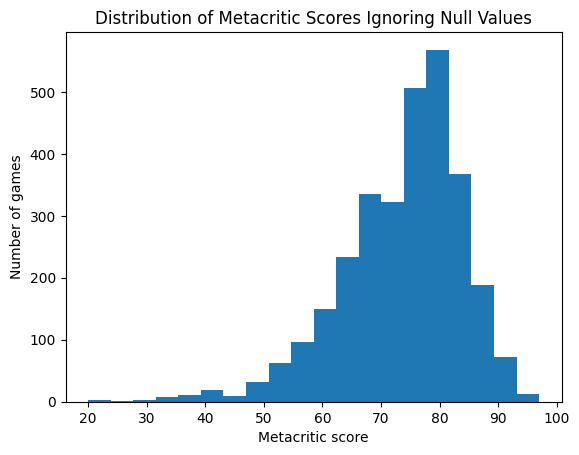

In [26]:
plt.hist(info_base_games_df['metacritic'].dropna(), bins=20)
plt.xlabel("Metacritic score")
plt.ylabel("Number of games")
plt.title("Distribution of Metacritic Scores Ignoring Null Values")
plt.show()

The above histogram shows that the **metacritic scores are normally distributed**, which means **we can apply standardization on it**.  
BUT before applying standardization or any similar preprocessing techniques we **must merge the dataframes** and **split the data into train-test** so that we can **ensure no data leakage occurs during preprocessing** by fitting the preprocessing techniques only on the training data and then transforming both the training and test data.

## Merge DataFrames

In [27]:
gamalytic_steam_games_df.rename(columns={"steamId": "appid"}, inplace=True)

# Ensure both DataFrames have the same data type for 'appid'
info_base_games_df['appid'] = info_base_games_df['appid'].astype(int)
gamalytic_steam_games_df['appid'] = gamalytic_steam_games_df['appid'].astype(int)

print("\nMerging DataFrames...")

# Merge info_base_games_df with gamalytic_steam_games_df into a new DataFrame
merged_df = info_base_games_df.merge(gamalytic_steam_games_df, on="appid", how="inner")
print(f"Rows after gamalytic_steam_games_df merge: {len(merged_df)}")

# Merge demo_indicators with merged_df
merged_df = merged_df.merge(demo_indicators, on="appid", how="left")
print(f"Rows after demo_indicators merge: {len(merged_df)}")

# Merge dlc_indicators with merged_df
merged_df = merged_df.merge(dlc_indicators, on="appid", how="left")
print(f"Rows after dlc_indicators merge: {len(merged_df)}")



Merging DataFrames...
Rows after gamalytic_steam_games_df merge: 69426
Rows after demo_indicators merge: 69426
Rows after dlc_indicators merge: 69426


## Split Data Into Training, Validation, and Testing Sets

In [28]:
X = merged_df.drop('copiesSold', axis=1)
Y = merged_df['copiesSold']

# 80% training, 10% validation, 10% testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, Y,
    test_size = 0.10,
    random_state = 123
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size = 0.1111,
    random_state = 123
)

df_train = pd.concat([X_train, y_train], axis=1)
df_val   = pd.concat([X_val,   y_val],   axis=1)
df_test  = pd.concat([X_test,  y_test],  axis=1)

print(f"Training set:   {df_train.shape}")
print(f"Validation set: {df_val.shape}")
print(f"Testing set:    {df_test.shape}")

Training set:   (55541, 23)
Validation set: (6942, 23)
Testing set:    (6943, 23)


## Complete Preprocessing Game Base Info CSV

### Complete Preprocessing Metacritic Column

#### Metacritic scores before standardization

In [29]:
df_train['metacritic'].dropna().head()

25086    79.0
67174    83.0
23970    54.0
56142    62.0
55976    66.0
Name: metacritic, dtype: float64

#### Standardizing metacritic scores

In [30]:
standardizer = StandardScaler()

df_train['metacritic_preprocessed'] = standardizer.fit_transform(df_train[['metacritic']])
df_val['metacritic_preprocessed'] = standardizer.transform(df_val[['metacritic']])
df_test['metacritic_preprocessed'] = standardizer.transform(df_test[['metacritic']])

df_train['metacritic_preprocessed'].dropna().head()

25086    0.509662
67174    0.903938
23970   -1.954561
56142   -1.166010
55976   -0.771734
Name: metacritic_preprocessed, dtype: float64

Now a problem remains, which is the missing values, it doesn't make sense to drop all the rows that don't contain a metacritic score since 97% of the data doesn't have it, the best solution that came to my mind is to **set all the NaN metacritic scores** to be equal to the **mean of the standardized metacritic scores**, which is **0**. And create a new boolean feature `has_metacritic` which indicates whether this game has a metacritic score or not, I hope that this can help models understand that if `has_metacritic = 0` then ignore this metacritic score, and also generally `has_metacritic` may later on turn out to be a useful feature on its own.

#### Creating New `has_metacritic` Feature

In [31]:
for df in (df_train, df_val, df_test):
    df['has_metacritic'] = df['metacritic'].notna().astype(int)
print(df_train['has_metacritic'].head())

11655    0
9303     0
56618    0
55579    0
64439    0
Name: has_metacritic, dtype: int64


#### Replacing Missing Values With the Mean Value

##### Before

In [32]:
df_train['metacritic_preprocessed'].head()

11655   NaN
9303    NaN
56618   NaN
55579   NaN
64439   NaN
Name: metacritic_preprocessed, dtype: float64

##### After

In [33]:
for df in (df_train, df_val, df_test):
    df['metacritic_preprocessed'] = df['metacritic_preprocessed'].fillna(0)
print(df_train['metacritic_preprocessed'].head())

11655    0.0
9303     0.0
56618    0.0
55579    0.0
64439    0.0
Name: metacritic_preprocessed, dtype: float64


In [34]:
df_train.head()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,supported_platforms,is_release_date_known,...,publisherClass,reviewScore,aiContent,has_demo,demo_count,has_dlc,dlc_count,copiesSold,metacritic_preprocessed,has_metacritic
11655,2900800,Physical Spheres,NaN,False,False,False,Casual,NaN,['windows'],1,...,Hobbyist,0,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0
9303,3017540,Slice Of Ages,NaN,False,False,False,"Action, Adventure, Indie, RPG, Free To Play",NaN,['windows'],1,...,Hobbyist,93,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0
56618,4290,RACE: Caterham Expansion,NaN,False,False,False,Racing,NaN,['windows'],1,...,Indie,46,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0
55579,1111760,World of Guns: VR,NaN,True,False,False,"Free To Play, Simulation",40.0,['windows'],1,...,Indie,37,NaN,NaN,NaN,NaN,NaN,Gold,0.0,0
64439,765480,Karambola,NaN,True,False,False,"Adventure, Casual, Indie, Free To Play",10.0,"['windows', 'mac', 'linux']",1,...,Hobbyist,97,NaN,NaN,NaN,1.0,1.0,Gold,0.0,0


#### Final Thoughts On Preprocessing Metacritic

The above concludes my current trials to preprocess the metacritic column. I will leave below some thoughts that we may wish to revisit in the future:
1. I am not sure if the imputation technique that I used is the most suitable technique for this case, and I am not sure if it is correct to standardize then impute, or should I impute first then standardize, I chose the first approach since I think this will better maintain the distribution of the original data, and especially since I believe the imputed value shouldn't have any more meaning than just indicating that this row didn't have a metacritic value, which I tried to do along with the `has_metacritic` column.

2. Most importantly, I believe later on the `metacritic` column **will turn out to not be useful** for our models and that we will remove it as a feature, this is based on some discussions I read ([discussion1](https://Steamcommunity.com/discussions/forum/10/3057367211653181335/?l=latam), [discussion2](https://www.reddit.com/r/pcgaming/comments/1gjadpf/da_tv_metacritic_user_score_vs_Steam_ratings/)) in which multiple people feel that it doesn't give accurate reviews, I also expect that it might have a high correlation with `reviewScore` in `gamalytic_Steam_games.csv`, and considering that a small number of samples have this score, I expect this feature won't be useful, on the other hand, I believe we might find the new `has_metacritic` feature useful on its own, still this is all just speculations and we will find out by using proper feature selection methods.

### Preprocess Genres Column

In [35]:
df_train['genres'].head()

11655                                         Casual
9303     Action, Adventure, Indie, RPG, Free To Play
56618                                         Racing
55579                       Free To Play, Simulation
64439         Adventure, Casual, Indie, Free To Play
Name: genres, dtype: object

##### Split Genres Into Lists

In [36]:
for df in (df_train, df_val, df_test):
    df['genres_split'] = df['genres'].fillna('')
    df['genres_split'] = df['genres_split'].apply(lambda x: x.split(', ') if x else [])

df_train['genres_split'].head()

11655                                         [Casual]
9303     [Action, Adventure, Indie, RPG, Free To Play]
56618                                         [Racing]
55579                       [Free To Play, Simulation]
64439         [Adventure, Casual, Indie, Free To Play]
Name: genres_split, dtype: object

#### Analyze Genres

Flatten genres into one big list

In [37]:
all_genres = [genre
              for sublist in df_train['genres_split']
              for genre in sublist]

Count genres frequencies

In [38]:
genre_counts = Counter(all_genres)
genre_freq = (
    pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
      .sort_values('count', ascending=False)
)
print("Number of uniqure genres in the whole dataset:")
print(genre_freq.size)
print(genre_freq)

Number of uniqure genres in the whole dataset:
27
                       count
Indie                  39712
Casual                 24463
Action                 22945
Adventure              22290
Simulation             11655
Strategy               11085
RPG                    10441
Early Access            5681
Free To Play            5659
Sports                  2309
Racing                  2067
Massively Multiplayer   1323
Violent                  253
Gore                     157
Nudity                    54
Sexual Content            54
Education                 18
Animation & Modeling      12
Utilities                 10
Game Development           9
Design & Illustration      8
Software Training          8
Audio Production           5
Video Production           3
Web Publishing             2
Accounting                 1
Photo Editing              1


Output word cloud for visualization of the genre counts

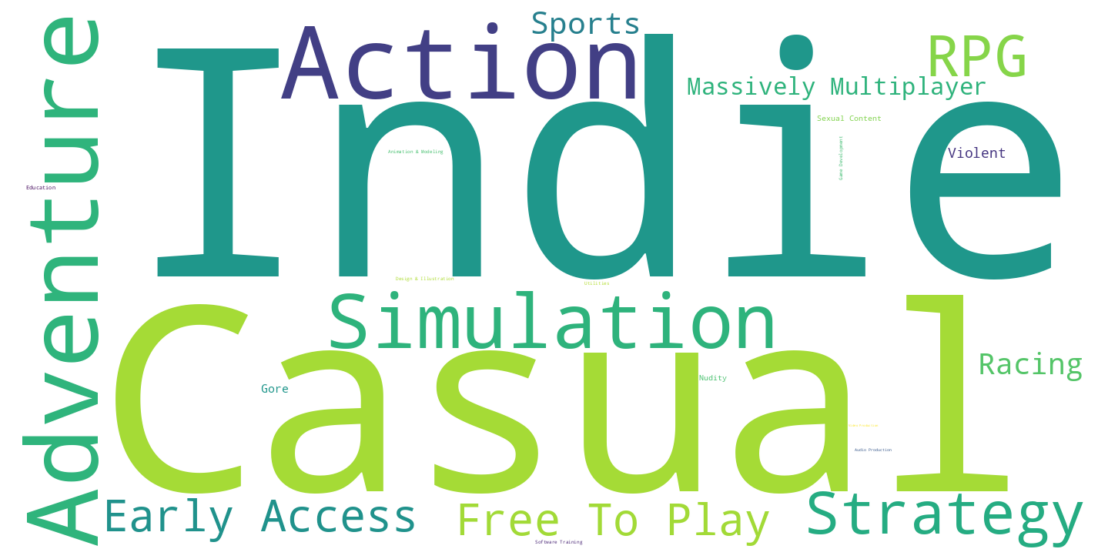

In [39]:
wc = WordCloud(width=1400, height=700, background_color='white')
wc.generate_from_frequencies(genre_counts)

plt.figure(figsize=(14, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Multi-Hot Encode The Genres and Merge Them Into the Dataframe

##### First, replace genres that are non-related to games with 'Other'

In [40]:
non_game_genres = [
    'Photo Editing', 'Video Production', 'Web Publishing', 'Accounting',
    'Audio Production', 'Software Training', 'Design & Illustration',
    'Utilities', 'Game Development', 'Education', 'Animation & Modeling'
]

def replace_non_game_genres(genres_list):
    return [
        genre if genre not in non_game_genres else 'Other'
        for genre in genres_list
    ]

for df in (df_train, df_val, df_test):
    df['genres_processed'] = df['genres_split'].apply(replace_non_game_genres)

In [41]:
mlb = MultiLabelBinarizer()

train_genres_encoded = mlb.fit_transform(df_train['genres_processed'])
train_genres_df = pd.DataFrame(train_genres_encoded, columns=[f'genre_{c}' for c in mlb.classes_], index=df_train.index)
df_train = pd.concat([df_train, train_genres_df], axis=1)

known_genres = set(mlb.classes_)

# Function to filter unseen genres so no errors occur if unseen genres are met during transform
def filter_unseen_genres(genres_list):
    return [genre for genre in genres_list if genre in known_genres]

df_val['genres_processed'] = df_val['genres_processed'].apply(lambda x: filter_unseen_genres(x))
val_genres_encoded = mlb.transform(df_val['genres_processed'])
val_genres_df = pd.DataFrame(val_genres_encoded, columns=[f'genre_{c}' for c in mlb.classes_], index=df_val.index)
df_val = pd.concat([df_val, val_genres_df], axis=1)

df_test['genres_processed'] = df_test['genres_processed'].apply(lambda x: filter_unseen_genres(x))
test_genres_encoded = mlb.transform(df_test['genres_processed'])
test_genres_df = pd.DataFrame(test_genres_encoded, columns=[f'genre_{c}' for c in mlb.classes_], index=df_test.index)
df_test = pd.concat([df_test, test_genres_df], axis=1)

for df in (df_train, df_val, df_test):
    df.drop(columns=['genres_split', 'genres_processed'], inplace=True)

In [42]:
pd.set_option('display.max_columns', None)
df_train.head()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,supported_platforms,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,publisherClass,reviewScore,aiContent,has_demo,demo_count,has_dlc,dlc_count,copiesSold,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent
11655,2900800,Physical Spheres,NaN,False,False,False,Casual,NaN,['windows'],1,0.0,2024,0.230306,-0.973118,0.99,Hobbyist,0,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9303,3017540,Slice Of Ages,NaN,False,False,False,"Action, Adventure, Indie, RPG, Free To Play",NaN,['windows'],1,0.0,2024,-0.060213,-0.998186,0.00,Hobbyist,93,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
56618,4290,RACE: Caterham Expansion,NaN,False,False,False,Racing,NaN,['windows'],1,0.0,2007,0.179767,-0.983709,3.99,Indie,46,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
55579,1111760,World of Guns: VR,NaN,True,False,False,"Free To Play, Simulation",40.0,['windows'],1,0.0,2019,-0.188227,0.982126,0.00,Indie,37,NaN,NaN,NaN,NaN,NaN,Gold,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
64439,765480,Karambola,NaN,True,False,False,"Adventure, Casual, Indie, Free To Play",10.0,"['windows', 'mac', 'linux']",1,0.0,2022,0.280231,-0.959933,0.00,Hobbyist,97,NaN,NaN,NaN,1.0,1.0,Gold,0.0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0


##### Final Thoughts On Preprocessing Genres

1. There are rare genres (Accounting, Nudity, Web Publishing, etc.), after research I believe we have 2 options that we can do with them, either treat them normally like all the other genres as I did above, or set a certain frequency threshold, and genres that have frequencies less than that threshold get removed and we replace them with a "genre_Other" column, I didn't do that since I have a feeling that these rare genres might help during prediction, but the best way to know would be to test both methods in the "training and evaluation" phase to determine which method helps the model make better predictions.

2. About handling unseen genres that we might get later on with unseen data, if we do not have the "genre_Other" column then the best way to handle them would be to ignore them, put 1's in the genres that we know, and ignore the ones we don't know, on the other hand if we have a "genre_Other" column, then we would put a 1 at that column.

3. If later on the genres prove to be useful in predictions and we select them as a feature, I believe the best way to handle them being missing in unseen data would be to webscrape and get the genres of the game.

4. Can later on try creating a new feature which is `number_of_genres`

### Preprocess Supported Platforms Column

#### Analyzing the column

In [43]:
df_train['supported_platforms'].value_counts()

supported_platforms
['windows']                    39501
['windows', 'mac', 'linux']     9539
['windows', 'mac']              4674
['windows', 'linux']            1822
['mac']                            4
['mac', 'linux']                   1
Name: count, dtype: int64

#### Multi-Hot Encode The Supported Platforms and Merge Them Into the Dataframe

In [44]:
# Safely convert the supported_platforms list into a python list
df_train['platforms_parsed'] = df_train['supported_platforms'].apply(ast.literal_eval)
df_val['platforms_parsed']   = df_val['supported_platforms'].apply(ast.literal_eval)
df_test['platforms_parsed']  = df_test['supported_platforms'].apply(ast.literal_eval)

mlb = MultiLabelBinarizer()

train_platforms_encoded = mlb.fit_transform(df_train['platforms_parsed'])
train_platforms_df = pd.DataFrame(train_platforms_encoded, columns=[f'platform_{c}' for c in mlb.classes_], index=df_train.index)
df_train = pd.concat([df_train, train_platforms_df], axis=1)

val_platforms_encoded = mlb.transform(df_val['platforms_parsed'])
val_platforms_df = pd.DataFrame(val_platforms_encoded, columns=[f'platform_{c}' for c in mlb.classes_], index=df_val.index)
df_val = pd.concat([df_val, val_platforms_df], axis=1)

test_platforms_encoded = mlb.transform(df_test['platforms_parsed'])
test_platforms_df = pd.DataFrame(test_platforms_encoded, columns=[f'platform_{c}' for c in mlb.classes_], index=df_test.index)
df_test = pd.concat([df_test, test_platforms_df], axis=1)

for df in (df_train, df_val, df_test):
    df.drop(columns=['supported_platforms','platforms_parsed'], inplace=True)

In [45]:
df_train.head()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,publisherClass,reviewScore,aiContent,has_demo,demo_count,has_dlc,dlc_count,copiesSold,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows
11655,2900800,Physical Spheres,NaN,False,False,False,Casual,NaN,1,0.0,2024,0.230306,-0.973118,0.99,Hobbyist,0,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9303,3017540,Slice Of Ages,NaN,False,False,False,"Action, Adventure, Indie, RPG, Free To Play",NaN,1,0.0,2024,-0.060213,-0.998186,0.00,Hobbyist,93,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
56618,4290,RACE: Caterham Expansion,NaN,False,False,False,Racing,NaN,1,0.0,2007,0.179767,-0.983709,3.99,Indie,46,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
55579,1111760,World of Guns: VR,NaN,True,False,False,"Free To Play, Simulation",40.0,1,0.0,2019,-0.188227,0.982126,0.00,Indie,37,NaN,NaN,NaN,NaN,NaN,Gold,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
64439,765480,Karambola,NaN,True,False,False,"Adventure, Casual, Indie, Free To Play",10.0,1,0.0,2022,0.280231,-0.959933,0.00,Hobbyist,97,NaN,NaN,NaN,1.0,1.0,Gold,0.0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1


### Preprocess Achievements Columns

In [46]:
df_train['achievements_total'].isnull().sum()/df_train.shape[0] #0.46

# Convert 'Total achievement' to number, and if there errors set them null
for df in (df_train, df_val, df_test):
    df['achievements_total'] = pd.to_numeric(df['achievements_total'], errors='coerce')

# if total achievement has value and steam achievement is false so convert it into true
for df in (df_train, df_val, df_test):
    df.loc[(df['achievements_total'] > 0) & (df['steam_achievements'] == False), 'steam_achievements'] = True

# if steam achievement is false and achievement total is null so set it zero
for df in (df_train, df_val, df_test):
    df.loc[df['steam_achievements'] == False, 'achievements_total'] = 0

# using KNN Imputer for fill null values of total achievement if steam achievement is true 
#mask = (info_base_games_df['steam_achievements'] == True)
#rows = info_base_games_df.loc[mask, ['achievements_total']]
#imputer = KNNImputer(n_neighbors=5)
#imputed = imputer.fit_transform(rows)
#info_base_games_df.loc[mask, 'achievements_total'] = np.floor(imputed)

# another option you can use median (not affected by outliers) / mean
median_val = df_train.loc[df_train['steam_achievements'] == True, 'achievements_total'].median()

for df in (df_train, df_val, df_test):
    df.loc[(df['steam_achievements'] == True) & (df['achievements_total'].isna()), 'achievements_total'] = median_val

#mean_val = info_base_games_df.loc[info_base_games_df['steam_achievements'] == True, 'achievements_total'].mean()
#print(median_val) #18
#print(mean_val)   # 40


# convert boolean to int (0,1)
for df in (df_train, df_val, df_test):
    df['steam_achievements'] = df['steam_achievements'].astype(int)

st_scaler = StandardScaler()

df_train['achievements_total'] = st_scaler.fit_transform(df_train[['achievements_total']])
df_val['achievements_total']  = st_scaler.transform(df_val[['achievements_total']])
df_test['achievements_total'] = st_scaler.transform(df_test[['achievements_total']])

In [47]:
df_train.head()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,publisherClass,reviewScore,aiContent,has_demo,demo_count,has_dlc,dlc_count,copiesSold,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows
11655,2900800,Physical Spheres,NaN,0,False,False,Casual,-0.127185,1,0.0,2024,0.230306,-0.973118,0.99,Hobbyist,0,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9303,3017540,Slice Of Ages,NaN,0,False,False,"Action, Adventure, Indie, RPG, Free To Play",-0.127185,1,0.0,2024,-0.060213,-0.998186,0.00,Hobbyist,93,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
56618,4290,RACE: Caterham Expansion,NaN,0,False,False,Racing,-0.127185,1,0.0,2007,0.179767,-0.983709,3.99,Indie,46,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
55579,1111760,World of Guns: VR,NaN,1,False,False,"Free To Play, Simulation",0.105103,1,0.0,2019,-0.188227,0.982126,0.00,Indie,37,NaN,NaN,NaN,NaN,NaN,Gold,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
64439,765480,Karambola,NaN,1,False,False,"Adventure, Casual, Indie, Free To Play",-0.069113,1,0.0,2022,0.280231,-0.959933,0.00,Hobbyist,97,NaN,NaN,NaN,1.0,1.0,Gold,0.0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1


#### Final Thoughts

I recommend making web scraping, it will be better and more accurate for sure instead of filling nulls with mean/median/imputers 
but we must put into consideration if it is possible or not.

### Preprocess App id, Name and 3 Boolean Columns

##### Data Statistics

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55541 entries, 11655 to 53785
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   appid                        55541 non-null  int64  
 1   name                         55541 non-null  object 
 2   metacritic                   2321 non-null   float64
 3   steam_achievements           55541 non-null  int64  
 4   steam_trading_cards          55541 non-null  bool   
 5   workshop_support             55541 non-null  bool   
 6   genres                       55456 non-null  object 
 7   achievements_total           55541 non-null  float64
 8   is_release_date_known        55541 non-null  int64  
 9   is_upcoming                  55541 non-null  float64
 10  year                         55541 non-null  int64  
 11  sin_day                      55541 non-null  float64
 12  cos_day                      55541 non-null  float64
 13  price            

- Notice that appid, steam_achievements, steam_trading_cards and workshop_support, all have no NULL values
- name has some NULL values

##### Calculate percentage of missing names:

In [49]:
missing_pct = df_train['name'].isna().mean() * 100
print(f"{missing_pct:.2f}% of games have no name")

0.00% of games have no name


- Since percentage is very low, rows with no names can be dropped with no real impact

##### Drop rows with NULL value names

In [50]:
original_length = len(df_train) + len(df_val) + len(df_test)

df_train.dropna(subset=['name'], inplace=True)
df_val.dropna(subset=['name'], inplace=True)
df_test.dropna(subset=['name'], inplace=True)

print(f"Dropped {original_length - (len(df_train) + len(df_val) + len(df_test))} rows with missing names.")

Dropped 0 rows with missing names.


##### Preprocess names and add features derived from name that could be useful


Preprocess names
- To lowercase
- Strip punctuation


features derived from name
- Character count
- Word count
- Ratio of capital letters to total length
- Is a sequel 
- Has useful keywords like (vr, remaster, collector, edition, bundle, playtest)

In [51]:
roman_re = re.compile(r'\b(?:i{1,3}|iv|v|vi|vii|viii|ix|x)\b')
digit_re = re.compile(r'\b[2-9]\b')
keywords = ['vr', 'remaster', 'collector', 'collection', 'edition', 'bundle', 'playtest']

def cap_ratio(s):
    if not s:
        return 0
    upper_count = sum(1 for ch in s if ch.isupper())
    return upper_count / len(s)

for df in (df_train, df_val, df_test):
    # Strip punctuation
    df['name'] = df['name'].str.replace(r'[^\w\s]', '', regex=True)

    # add character count and word count features
    df['name_len'] = df['name'].str.len()
    df['name_words'] = df['name'].str.split().str.len()

    # add caps ratio feature
    df['name_cap_ratio'] = df['name'].apply(cap_ratio)

    # transform all names to lowercase
    df['name'] = df['name'].str.lower()

    # check if game is a sequel and add is_sequel feature
    df['is_sequel'] = (
        df['name'].str.contains(roman_re) |
        df['name'].str.contains(digit_re)
    ).astype(int)

    # add useful keyword features
    for kw in keywords:
        df[f'name_has_{kw}'] = df['name'].str.contains(fr'\b{kw}\b').astype(int)

df_train.head()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,publisherClass,reviewScore,aiContent,has_demo,demo_count,has_dlc,dlc_count,copiesSold,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest
11655,2900800,physical spheres,NaN,0,False,False,Casual,-0.127185,1,0.0,2024,0.230306,-0.973118,0.99,Hobbyist,0,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16,2,0.125000,0,0,0,0,0,0,0,0
9303,3017540,slice of ages,NaN,0,False,False,"Action, Adventure, Indie, RPG, Free To Play",-0.127185,1,0.0,2024,-0.060213,-0.998186,0.00,Hobbyist,93,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,13,3,0.230769,0,0,0,0,0,0,0,0
56618,4290,race caterham expansion,NaN,0,False,False,Racing,-0.127185,1,0.0,2007,0.179767,-0.983709,3.99,Indie,46,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,23,3,0.260870,0,0,0,0,0,0,0,0
55579,1111760,world of guns vr,NaN,1,False,False,"Free To Play, Simulation",0.105103,1,0.0,2019,-0.188227,0.982126,0.00,Indie,37,NaN,NaN,NaN,NaN,NaN,Gold,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,16,4,0.250000,0,1,0,0,0,0,0,0
64439,765480,karambola,NaN,1,False,False,"Adventure, Casual, Indie, Free To Play",-0.069113,1,0.0,2022,0.280231,-0.959933,0.00,Hobbyist,97,NaN,NaN,NaN,1.0,1.0,Gold,0.0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,9,1,0.111111,0,0,0,0,0,0,0,0


Apply pretrained embeddings on names

In [52]:
# COMMENTED FOR NOW DUE TO ITS COMPLEXITY AND HIGH DIMENSIONALITY

# model = SentenceTransformer('all-MiniLM-L6-v2')

# train_embeddings = model.encode(df_train['name'].tolist())
# emb_dim = train_embeddings.shape[1]
# emb_cols = [f'name_emb_{i}' for i in range(emb_dim)]
# train_emb_df = pd.DataFrame(train_embeddings, columns=emb_cols, index=df_train.index)
# df_train = pd.concat([df_train, train_emb_df], axis=1)

# val_embeddings = model.encode(df_val['name'].tolist())
# val_emb_df = pd.DataFrame(val_embeddings, columns=emb_cols, index=df_val.index)
# df_val = pd.concat([df_val, val_emb_df], axis=1)

# test_embeddings = model.encode(df_test['name'].tolist())
# test_emb_df = pd.DataFrame(test_embeddings, columns=emb_cols, index=df_test.index)
# df_test = pd.concat([df_test, test_emb_df], axis=1)

Scale numeric features (optional depending on model's sensitivity to data scale)

In [53]:
scale_cols = [
    'name_len', 'name_words', 'name_cap_ratio', 'is_sequel'
] + [f'name_has_{kw}' for kw in keywords]

scaler = StandardScaler()

df_train[scale_cols] = scaler.fit_transform(df_train[scale_cols])
df_val[scale_cols]   = scaler.transform(df_val[scale_cols])
df_test[scale_cols]  = scaler.transform(df_test[scale_cols])

##### Turn boolean columns into numeric

In [54]:
for df in (df_train, df_val, df_test):
    df['steam_achievements'] = df['steam_achievements'].astype(int)
    df['steam_trading_cards'] = df['steam_trading_cards'].astype(int)
    df['workshop_support'] = df['workshop_support'].astype(int)

##### Statistics After Preprocessing

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55541 entries, 11655 to 53785
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   appid                        55541 non-null  int64  
 1   name                         55541 non-null  object 
 2   metacritic                   2321 non-null   float64
 3   steam_achievements           55541 non-null  int64  
 4   steam_trading_cards          55541 non-null  int64  
 5   workshop_support             55541 non-null  int64  
 6   genres                       55456 non-null  object 
 7   achievements_total           55541 non-null  float64
 8   is_release_date_known        55541 non-null  int64  
 9   is_upcoming                  55541 non-null  float64
 10  year                         55541 non-null  int64  
 11  sin_day                      55541 non-null  float64
 12  cos_day                      55541 non-null  float64
 13  price            

##### Summary and Conclusion

- Imported & cleaned
  - Installed and loaded `sentence-transformers`, `pandas`, `re`, and `StandardScaler`  
  - Read in `info_base_games.csv` and inspected column completeness  

- Handled missing titles
  - Calculated missing‑name percentage and dropped rows (low impact)  

- Engineered name features
  - Normalized titles (lowercase, no punctuation)  
  - Character count (`name_len`)  
  - Word count (`name_words`)  
  - Capital‑letter ratio (`name_cap_ratio`)  
  - Sequel flag (`is_sequel`) identified from standalone roman numerals or digits  
  - Keyword flags (`name_has_vr`, `name_has_remaster`, etc.)

- Applied embeddings 
  - Generated embedding vectors from `all-MiniLM-L6-v2` for each cleaned name  

- Scaled & encoded  
  - Standardized numeric features (`name_len`, `name_words`, `name_cap_ratio`, `is_sequel`, keyword flags)  
  - Converted boolean columns (`steam_achievements`, `steam_trading_cards`, `workshop_support`) into numeric 0/1  

- Saved & validated  
  - (Optional) Exported the preprocessed DataFrame into csv
  - Reviewed final schema and data types

- Notes
  - Scaling numeric features should be applied or ignored depending on the model type and sensitivity to scaling
  - `app_id` will most likely be dropped since it has no useful impact on sales

## Preprocessing Gamalytic CSV

### Preprocess Steam ID, Publisher Class, and AI Content Columns

#### Statistics Before Preprocessing

In [56]:
df_train.shape

(55541, 55)

In [57]:
df_train.head()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,publisherClass,reviewScore,aiContent,has_demo,demo_count,has_dlc,dlc_count,copiesSold,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest
11655,2900800,physical spheres,NaN,0,0,0,Casual,-0.127185,1,0.0,2024,0.230306,-0.973118,0.99,Hobbyist,0,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.129008,-0.485228,-0.422150,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0
9303,3017540,slice of ages,NaN,0,0,0,"Action, Adventure, Indie, RPG, Free To Play",-0.127185,1,0.0,2024,-0.060213,-0.998186,0.00,Hobbyist,93,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.430898,0.109341,0.140908,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0
56618,4290,race caterham expansion,NaN,0,0,0,Racing,-0.127185,1,0.0,2007,0.179767,-0.983709,3.99,Indie,46,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.575401,0.109341,0.301146,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0
55579,1111760,world of guns vr,NaN,1,0,0,"Free To Play, Simulation",0.105103,1,0.0,2019,-0.188227,0.982126,0.00,Indie,37,NaN,NaN,NaN,NaN,NaN,Gold,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.129008,0.703911,0.243282,-0.241008,7.064584,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0
64439,765480,karambola,NaN,1,0,0,"Adventure, Casual, Indie, Free To Play",-0.069113,1,0.0,2022,0.280231,-0.959933,0.00,Hobbyist,97,NaN,NaN,NaN,1.0,1.0,Gold,0.0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,-0.833418,-1.079798,-0.496087,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0


In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55541 entries, 11655 to 53785
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   appid                        55541 non-null  int64  
 1   name                         55541 non-null  object 
 2   metacritic                   2321 non-null   float64
 3   steam_achievements           55541 non-null  int64  
 4   steam_trading_cards          55541 non-null  int64  
 5   workshop_support             55541 non-null  int64  
 6   genres                       55456 non-null  object 
 7   achievements_total           55541 non-null  float64
 8   is_release_date_known        55541 non-null  int64  
 9   is_upcoming                  55541 non-null  float64
 10  year                         55541 non-null  int64  
 11  sin_day                      55541 non-null  float64
 12  cos_day                      55541 non-null  float64
 13  price            

#### Publisher Class Column

In [59]:
df_train['publisherClass'].value_counts()

publisherClass
Hobbyist    31643
Indie       21502
AA           1748
AAA           648
Name: count, dtype: int64

In [60]:
if TARGET_TYPE == TargetType.REGRESSION:
    grouped = df_train.groupby('publisherClass')['copiesSold'].sum().sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x=grouped.index, y=grouped.values, palette='viridis')
    plt.title('Total Copies Sold by Publisher Class')
    plt.xlabel('Publisher Class')
    plt.ylabel('Copies Sold')
    plt.show()

 As dataset rows equals 93338 i think we can replace AA and AAA columns with only one column for others and this also may handle unseen data in testing

In [61]:
mapping = {'AA': 'Other', 'AAA': 'Other'}

df_train['publisherClass'] = df_train['publisherClass'].replace(mapping)
df_val['publisherClass'] = df_val['publisherClass'].replace(mapping)
df_test['publisherClass'] = df_test['publisherClass'].replace(mapping)

print(df_train['publisherClass'].value_counts())

publisherClass
Hobbyist    31643
Indie       21502
Other        2396
Name: count, dtype: int64


#### Using Dummy Encoding (A Smarter Way Of Doing One Hot Encoding)

In [62]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_train = encoder.fit_transform(df_train[['publisherClass']])
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(['publisherClass']), index=df_train.index)
df_train = pd.concat([df_train, encoded_train_df], axis=1)
df_train.drop('publisherClass', axis=1, inplace=True)

encoded_val = encoder.transform(df_val[['publisherClass']])
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(['publisherClass']), index=df_val.index)
df_val = pd.concat([df_val, encoded_val_df], axis=1)
df_val.drop('publisherClass', axis=1, inplace=True)

encoded_test = encoder.transform(df_test[['publisherClass']])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(['publisherClass']), index=df_test.index)
df_test = pd.concat([df_test, encoded_test_df], axis=1)
df_test.drop('publisherClass', axis=1, inplace=True)

In [63]:
df_train.tail()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,reviewScore,aiContent,has_demo,demo_count,has_dlc,dlc_count,copiesSold,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest,publisherClass_Indie,publisherClass_Other
39195,1763210,waveplayer,NaN,0,0,0,"Action, Adventure",-0.127185,1,0.0,2021,-0.920971,0.389630,0.00,86,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,-0.732788,-1.079798,-0.022890,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
44789,1068700,mystery of the ancients deadly cold collectors...,NaN,0,0,0,"Adventure, Casual",-0.127185,1,0.0,2019,0.196673,-0.980469,9.99,87,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.694929,3.082189,-0.496087,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,7.988031,-0.012731,0.0,1.0,0.0
19833,661330,layers,NaN,1,0,0,"Casual, Indie",-0.069113,1,0.0,2017,-0.746972,0.664855,0.99,78,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,-1.135308,-1.079798,-0.200339,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
68023,3376510,cafe haven,NaN,1,0,0,"Indie, Simulation, Strategy",-0.022656,0,1.0,2025,0.699458,0.714673,4.99,100,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,-0.732788,-0.485228,-0.022890,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
53785,1165540,mad maze,NaN,0,0,0,"Adventure, Casual, Indie, RPG, Strategy",-0.127185,1,0.0,2019,-0.977848,0.209315,1.99,100,NaN,NaN,NaN,NaN,NaN,Bronze,0.0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,-0.934048,-0.485228,1.574147,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0


#### Dropping AI Content column as it contain 100% NULL values

In [64]:
df_train.drop('aiContent', axis=1, inplace=True)
df_val.drop('aiContent', axis=1, inplace=True)
df_test.drop('aiContent', axis=1, inplace=True)

### Preprocess Price, Copies Sold, and Reviews Columns

####  Identify Columns That Contain a Single Value
  - Columns that have a single observation or value are probably useless for modeling.

In [65]:
# Check if column has a single value
print(1, len(unique(df_train['price'])))
print(2, len(unique(df_train['copiesSold'])))
print(3, len(unique(df_train['reviewScore'])))

1 267
2 4
3 98


In [66]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 55541 entries, 11655 to 53785
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   appid                        55541 non-null  int64  
 1   name                         55541 non-null  object 
 2   metacritic                   2321 non-null   float64
 3   steam_achievements           55541 non-null  int64  
 4   steam_trading_cards          55541 non-null  int64  
 5   workshop_support             55541 non-null  int64  
 6   genres                       55456 non-null  object 
 7   achievements_total           55541 non-null  float64
 8   is_release_date_known        55541 non-null  int64  
 9   is_upcoming                  55541 non-null  float64
 10  year                         55541 non-null  int64  
 11  sin_day                      55541 non-null  float64
 12  cos_day                      55541 non-null  float64
 13  price            

#### If Target is Classification, Check The Value Counts

In [67]:
if TARGET_TYPE == TargetType.CLASSIFICATION:
    combined_copies_sold = pd.concat([
        df_train['copiesSold'],
        df_val['copiesSold'],
        df_test['copiesSold']
    ])
    print(combined_copies_sold.value_counts())

copiesSold
Bronze      35550
Silver      17994
Gold        10279
Platinum     5603
Name: count, dtype: int64


#### Check Duplicates

In [68]:
duplicates = df_train.duplicated()
print("Any duplicates ?", duplicates.any())
print("Duplicate rows:\n", df_train[duplicates])

Any duplicates ? False
Duplicate rows:
 Empty DataFrame
Columns: [appid, name, metacritic, steam_achievements, steam_trading_cards, workshop_support, genres, achievements_total, is_release_date_known, is_upcoming, year, sin_day, cos_day, price, reviewScore, has_demo, demo_count, has_dlc, dlc_count, copiesSold, metacritic_preprocessed, has_metacritic, genre_Action, genre_Adventure, genre_Casual, genre_Early Access, genre_Free To Play, genre_Gore, genre_Indie, genre_Massively Multiplayer, genre_Nudity, genre_Other, genre_RPG, genre_Racing, genre_Sexual Content, genre_Simulation, genre_Sports, genre_Strategy, genre_Violent, platform_linux, platform_mac, platform_windows, name_len, name_words, name_cap_ratio, is_sequel, name_has_vr, name_has_remaster, name_has_collector, name_has_collection, name_has_edition, name_has_bundle, name_has_playtest, publisherClass_Indie, publisherClass_Other]
Index: []


#### Remove Duplicates

In [69]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

# delete duplicate rows
for df in (df_train, df_val, df_test):
    df.drop_duplicates(inplace=True)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(55541, 55)
(6943, 55)
(6942, 55)


(55541, 55)
(6943, 55)
(6942, 55)


#### Count Missing Values

In [70]:
print(df_train[['price', 'copiesSold', 'reviewScore']].isna().sum())

if TARGET_TYPE == TargetType.REGRESSION:
    # Count how many rows have copiesSold == 0
    zero_sales = df_train[df_train['copiesSold'] == 0]
    print(zero_sales[['name', 'price', 'copiesSold', 'reviewScore']])

price          0
copiesSold     0
reviewScore    0
dtype: int64


#### Checking Inconsistent Values
 - Checking for Negative Values

In [71]:
# Check if any value is negative
negative_price = (df_train['price'] < 0).any() or (df_val['price'] < 0).any() or (df_test['price'] < 0).any()
print(f"Negative 'price' values: {negative_price}")

if TARGET_TYPE == TargetType.REGRESSION:
    negative_copies = (df_train['copiesSold'] < 0).any() or (df_val['copiesSold'] < 0).any() or (df_test['copiesSold'] < 0).any()
    print(f"Negative 'copiesSold' values: {negative_copies}")

negative_review = (df_train['reviewScore'] < 0).any() or (df_val['reviewScore'] < 0).any() or (df_test['reviewScore'] < 0).any()
print(f"Negative 'reviewScore' values: {negative_review}")

Negative 'price' values: False
Negative 'reviewScore' values: False


#### Transformation
 - Analyzing Skewness

In [72]:
# Check initial skewness of distributions
print(f"Price skewness: {skew(df_train['price']):.2f}")
print(f"reviewScore skewness: {skew(df_train['reviewScore']):.2f}")

if TARGET_TYPE == TargetType.REGRESSION:
    print(f"CopiesSold skewness: {skew(df_train['copiesSold']):.2f}")

Price skewness: 35.86
reviewScore skewness: -1.28


#### Log Transformation For Skewed Data

In [73]:
# Apply log transformation to reduce skewness
df_train['price'] = np.log1p(df_train['price'])
df_val  ['price'] = np.log1p(df_val['price'])
df_test ['price'] = np.log1p(df_test['price'])

if TARGET_TYPE == TargetType.REGRESSION:
    df_train['copiesSold'] = np.log1p(df_train['copiesSold'])
    df_val  ['copiesSold'] = np.log1p(df_val['copiesSold'])
    df_test ['copiesSold'] = np.log1p(df_test['copiesSold'])

#### Handling Outliers in Review Scores

In [74]:
low = df_train['reviewScore'].quantile(0.25)
high = df_train['reviewScore'].quantile(0.75)
median = df_train['reviewScore'].median()

df_train.loc[df_train['reviewScore'] < low,  'reviewScore'] = median
df_train.loc[df_train['reviewScore'] > high, 'reviewScore'] = high

df_val.loc[df_val['reviewScore'] < low,  'reviewScore'] = median
df_val.loc[df_val['reviewScore'] > high, 'reviewScore'] = high

df_test.loc[df_test['reviewScore'] < low,  'reviewScore'] = median
df_test.loc[df_test['reviewScore'] > high, 'reviewScore'] = high

#### Check skewness after transformation

In [75]:
# Check skewness after outlier treatment
print("After outlier treatment:")
print(f"Price skewness: {skew(df_train['price']):.2f}")
print(f"reviewScore skewness: {skew(df_train['reviewScore']):.2f}")

if TARGET_TYPE == TargetType.REGRESSION:
    print(f"CopiesSold skewness: {skew(df_train['copiesSold']):.2f}")

After outlier treatment:
Price skewness: -0.02
reviewScore skewness: -0.49


#### Feature Scaling

In [76]:
scaler = StandardScaler()
df_train[['price', 'reviewScore']] = scaler.fit_transform(df_train[['price', 'reviewScore']])
df_val[['price', 'reviewScore']] = scaler.transform(df_val[['price', 'reviewScore']])
df_test[['price', 'reviewScore']] = scaler.transform(df_test[['price', 'reviewScore']])

#### Visualization

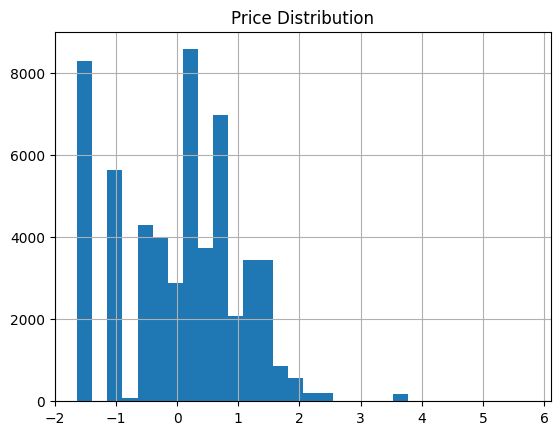

In [77]:
# Visualize distribution of prices
df_train['price'].hist(bins = 30)
plt.title('Price Distribution')
plt.show()

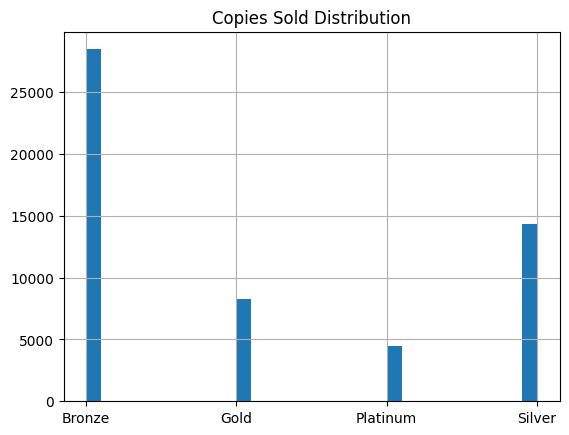

In [78]:
# Visualize distribution of copiesSold
df_train['copiesSold'].hist(bins = 30)
plt.title('Copies Sold Distribution')
plt.show()

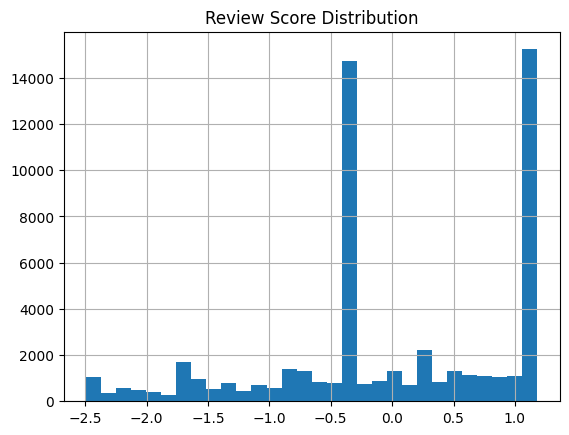

In [79]:
# Visualize distribution of Review Score
df_train['reviewScore'].hist(bins = 30)
plt.title('Review Score Distribution')
plt.show()

#### Dummy Encoding Copies Sold In Classification

In [80]:
if TARGET_TYPE == TargetType.CLASSIFICATION:
    encoder = OneHotEncoder(drop='first', sparse_output=False)

    encoded_train = encoder.fit_transform(df_train[['copiesSold']])
    encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(['copiesSold']), index=df_train.index)
    df_train = pd.concat([df_train, encoded_train_df], axis=1)
    df_train.drop('copiesSold', axis=1, inplace=True)

    encoded_val = encoder.transform(df_val[['copiesSold']])
    encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(['copiesSold']), index=df_val.index)
    df_val = pd.concat([df_val, encoded_val_df], axis=1)
    df_val.drop('copiesSold', axis=1, inplace=True)

    encoded_test = encoder.transform(df_test[['copiesSold']])
    encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(['copiesSold']), index=df_test.index)
    df_test = pd.concat([df_test, encoded_test_df], axis=1)
    df_test.drop('copiesSold', axis=1, inplace=True)

## Checking Final Preprocessed Results

### Check Duplicates

In [81]:
print(df_train.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

0
0
0


### Handle Additional NaNs

In [82]:
for df in [df_train, df_val, df_test]:
    df["has_demo"] = df["has_demo"].fillna(0).astype(int)
    df["demo_count"] = df["demo_count"].fillna(0).astype(int)
    df["has_dlc"] = df["has_dlc"].fillna(0).astype(int)
    df["dlc_count"] = df["dlc_count"].fillna(0).astype(int)
    
    df.drop(columns=["metacritic"], inplace=True)
    df['genres'] = df['genres'].fillna('')

### Results

In [83]:
# Check NaN counts after merge and imputation on each set
for name, df in zip(['Train', 'Validation', 'Test'], [df_train, df_val, df_test]):
    print(f"\n{name} NaN counts after merge and imputation:")
    nan_counts = df.isna().sum()
    print(nan_counts[nan_counts > 0].sort_values(ascending=False))
    print(f"\nRows in {name}: {len(df)}")
    print(df[["appid", "name", "metacritic_preprocessed", "has_metacritic", "achievements_total", "has_demo", "demo_count", "has_dlc", "dlc_count"]].head())


Train NaN counts after merge and imputation:
Series([], dtype: int64)

Rows in Train: 55541
         appid                     name  metacritic_preprocessed  \
11655  2900800         physical spheres                      0.0   
9303   3017540            slice of ages                      0.0   
56618     4290  race caterham expansion                      0.0   
55579  1111760         world of guns vr                      0.0   
64439   765480                karambola                      0.0   

       has_metacritic  achievements_total  has_demo  demo_count  has_dlc  \
11655               0           -0.127185         0           0        0   
9303                0           -0.127185         0           0        0   
56618               0           -0.127185         0           0        0   
55579               0            0.105103         0           0        0   
64439               0           -0.069113         0           0        1   

       dlc_count  
11655          0  
930

### Drop Original Columns That Won't Be Needed During Feature Selection And Training

In [84]:
for df in [df_train, df_val, df_test]:
    df.drop(columns=['appid', 'name', 'genres'], inplace=True)

## Summary

In [85]:
print("\nPreprocessing Summary:\n")
for name, df in zip(['Train', 'Validation', 'Test'], [df_train, df_val, df_test]):
    print(f"\n{name} DataFrame: {len(df)} rows, {len(df.columns)} columns")


Preprocessing Summary:


Train DataFrame: 55541 rows, 53 columns

Validation DataFrame: 6942 rows, 53 columns

Test DataFrame: 6943 rows, 53 columns


In [86]:
df_train.head(1)

,steam_achievements,steam_trading_cards,workshop_support,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,reviewScore,has_demo,demo_count,has_dlc,dlc_count,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest,publisherClass_Indie,publisherClass_Other,copiesSold_Gold,copiesSold_Platinum,copiesSold_Silver
11655,0,0,0,-0.127185,1,0.0,2024,0.230306,-0.973118,-0.959158,-0.331901,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.129008,-0.485228,-0.42215,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
df_val.head(1)

,steam_achievements,steam_trading_cards,workshop_support,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,reviewScore,has_demo,demo_count,has_dlc,dlc_count,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest,publisherClass_Indie,publisherClass_Other,copiesSold_Gold,copiesSold_Platinum,copiesSold_Silver
23530,0,0,0,-0.127185,1,0.0,2015,0.188227,0.982126,0.710056,-0.007857,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.776661,0.109341,-0.235829,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,1.0,0.0,0.0,1.0


In [88]:
df_test.head(1)

,steam_achievements,steam_trading_cards,workshop_support,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,reviewScore,has_demo,demo_count,has_dlc,dlc_count,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest,publisherClass_Indie,publisherClass_Other,copiesSold_Gold,copiesSold_Platinum,copiesSold_Silver
28272,0,0,0,-0.127185,1,0.0,2021,-0.845249,-0.534373,0.945815,1.180305,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.531528,-1.079798,-0.200339,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,1.0,0.0,0.0,0.0,0.0


## Save The Final Dataframe To Parquet

In [89]:
# Ensure output directory exists and if it doesn't, create it.
os.makedirs(OUTPUT_PATH, exist_ok=True)

df_train.to_parquet(OUTPUT_PATH+"train.parquet")
df_val.to_parquet(OUTPUT_PATH+"validation.parquet")
df_test.to_parquet(OUTPUT_PATH+"test.parquet")